# 通常のP値とBayes的な類似物がほぼ一致する場合

* 黒木玄
* 2022-08-01

ツイッターでの

* https://twitter.com/iznaiy_emjawak/status/1553717951273922560
* https://twitter.com/iznaiy_emjawak/status/1553741283025227781
* https://twitter.com/epidemia_jp/status/1553693080846417921
* https://twitter.com/epidemia_jp/status/1552902192670986240
* https://twitter.com/epidemia_jp/status/1552933838245941248

を見て存在を知った論文

* https://evidence.nejm.org/doi/full/10.1056/EVIDctw2200018
* https://arxiv.org/abs/2203.11164

の Julia による再現. 通常のP値とそのBayes的類似物がほぼ一致する場合について, 片側検定のP値のBayes的類似物をプロットしているだけであった.

__以下のJuliaによる再現が論文と違う所__

* 通常の信頼区間の計算をWald法で直接行った. `glm` の類を使うまでもない.

* 事前分布としてJeffreys事前分布(共役事前分布でおとなしめのものなら何でもよい)を採用した.  論文では logit 座標での正規分布を採用していたが, そういう難しいことをせずに, 共役事前分布を使えばシンプルにかつ効率的に計算できる.  そして, 二項分布モデルに関しては, 通常のP値と信頼区間と比較する場合には, Jeffreys事前分布を採用すると一致し易くなる.

* このように変更しても結果はほとんど変わらない.

In [1]:
using Distributions
using Random
using Roots
using StatsBase
using StatsFuns
using StatsPlots
default(fmt=:png, titlefontsize=10, plot_titlefontsize=12)

In [2]:
# リスク差のP値と信頼区間を計算する函数達

safemul(x, y) = x == 0 ? x : isinf(x) ? typeof(x)(Inf) : x*y
safediv(x, y) = x == 0 ? x : isinf(y) ? zero(y) : x/y

riskdiffhat(a, b, c, d) = safediv(a, a+b) - safediv(c, c+d)

function stderr_riskdiffhat(a, b, c, d)
    m, n = a+b, c+d
    p̂, q̂ = safediv(a, m), safediv(c, n)
    √(safediv(p̂*(1-p̂), m-1) + safediv(q̂*(1-q̂), n-1))
end

function pvalue_rd_wald(a, b, c, d; Δ=0)
    RDhat = riskdiffhat(a, b, c, d)
    SEhat_riskdiffhat = stderr_riskdiffhat(a, b, c, d)
    2ccdf(Normal(0, 1), safediv(abs(RDhat - Δ), SEhat_riskdiffhat))
end

function confint_rd_wald(a, b, c, d; α=0.05)
    z = quantile(Normal(), 1-α/2)
    RDhat = riskdiffhat(a, b, c, d)
    SEhat_riskdiffhat = stderr_riskdiffhat(a, b, c, d)
    [RDhat - z*SEhat_riskdiffhat, RDhat + z*SEhat_riskdiffhat]
end

# 以下の方法は
#
# Kenneth J. Rothman, Sander Greenland, and Timothy L. Lash
# Modern Epistemology, Third Edition, 2008, 888 pages
#
# の
#
# Chapter 14. Instroduction to Categorical Statistics
# Section. Two Study Groups: Large-Sample Methods, pp.299-300
#
# に書いてある. そこでは, 次の文献が引用されている:
#
# Guangyong Zou and Allan Donner
# A simple alternative confidence interval for the difference between two proportions
# Controlled Clinical Trials, Volume 25, Issue 1, February 2004, Pages 3-12
# https://doi.org/10.1016/j.cct.2003.08.010

function pvalue_rd_zou_donner(a, b, c, d; Δ=0)
    ((a==0 && d==0) || (b==0 && c==0)) && return 1.0
    RDhat = riskdiffhat(a, b, c, d)
    SEhat_riskdiffhat = stderr_riskdiffhat(a, b, c, d)
    Z = safediv((1 - RDhat^2)*abs(atanh(RDhat) - atanh(Δ)), SEhat_riskdiffhat)
    2ccdf(Normal(), abs(Z))
end

function confint_rd_zou_donner(a, b, c, d; α=0.05)
    z = quantile(Normal(), 1-α/2)
    RDhat = riskdiffhat(a, b, c, d)
    SEhat_riskdiffhat = stderr_riskdiffhat(a, b, c, d)
    m = atanh(RDhat)
    d = safediv(z*SEhat_riskdiffhat, 1 - RDhat^2)
    [tanh(m-d), tanh(m+d)]
end

confint_rd_zou_donner (generic function with 1 method)

In [3]:
function confint_rd(pvaluefunc; α=0.05)
    f(x) = pvaluefunc(x) - α
    find_zeros(f, -1, 1)
end

# 信頼区間函数達が正しいかどうかの確認

a, b, c, d = 426-255, 255, 433-277, 277

ci1 = @show confint_rd_wald(a, b, c, d; α=0.05)
f_wald(Δ) = pvalue_rd_wald(a, b, c, d; Δ)
ci2 = @show confint_rd(f_wald; α=0.05)
@show ci1 - ci2

ci1 = @show confint_rd_zou_donner(a, b, c, d; α=0.05)
f_zou_donner(Δ) = pvalue_rd_zou_donner(a, b, c, d; Δ)
ci2 = @show confint_rd(f_zou_donner; α=0.05)
@show ci1 - ci2
;

confint_rd_wald(a, b, c, d; α = 0.05) = [-0.023840140523149853, 0.10610276941427953]
confint_rd(f_wald; α = 0.05) = [-0.023840140523149745, 0.10610276941427942]
ci1 - ci2 = [-1.0755285551056204e-16, 1.1102230246251565e-16]
confint_rd_zou_donner(a, b, c, d; α = 0.05) = [-0.023922460793897343, 0.10583822418701612]
confint_rd(f_zou_donner; α = 0.05) = [-0.023922460793897236, 0.10583822418701601]
ci1 - ci2 = [-1.0755285551056204e-16, 1.1102230246251565e-16]


In [4]:
# 片側検定のP値函数

function ccdf_rd_wald(a, b, c, d; Δ=0)
    RDhat = riskdiffhat(a, b, c, d)
    SEhat_riskdiffhat = stderr_riskdiffhat(a, b, c, d)
    ccdf(Normal(0, 1), safediv(Δ - RDhat, SEhat_riskdiffhat))
end

ccdf_rd_wald (generic function with 1 method)

In [5]:
# Bayes統計版

function make_ecdf_posterior_rd(a, b, c, d; conjprior=(0.5, 0.5), L=10^6)
    posterior1 = Beta((conjprior .+ (a, b))...)
    posterior2 = Beta((conjprior .+ (c, d))...)
    P = rand(posterior1, L)
    Q = rand(posterior2, L)
    diff = P - Q
    _ecdf_delta = ecdf(diff)
    ecdf_rd_bayes(x) = _ecdf_delta(x)
    eccdf_rd_bayes(x) = 1 - _ecdf_delta(x)
    pvalue_rd_bayes(x) = min(1, 2ecdf_rd_bayes(x), 2eccdf_rd_bayes(x))
    (; ecdf_rd_bayes, eccdf_rd_bayes, pvalue_rd_bayes)
end

make_ecdf_posterior_rd (generic function with 1 method)

In [6]:
# グラフのプロット用の函数

function plot_ACCEPT(; data = earnest, unacceptable_diff = 0.0, legend = :left)
    @show data
    @show unacceptable_diff

    (; ecdf_rd_bayes, eccdf_rd_bayes, pvalue_rd_bayes) =
        make_ecdf_posterior_rd(data...; conjprior=(0.5, 0.5))
    @show riskdiffhat(data...)
    @show ecdf_rd_bayes._ecdf_delta.sorted_values |> mean
    @show ecdf_rd_bayes._ecdf_delta.sorted_values |> median
    ci_wald = @show confint_rd_wald(data...; α=0.05)
    ci_bayes = @show confint_rd(pvalue_rd_bayes; α=0.05)

    P0 = plot(; legend)
    plot!(Δ -> pvalue_rd_wald(data...; Δ), -0.15, 0.15; label="Wald")
    plot!(pvalue_rd_bayes, -0.15, 0.15; label="Bayesian", ls=:dash)
    vline!(ci_wald; label="95% CI (Wald)")
    vline!(ci_bayes; label="95% CI (Bayesian)", ls=:dash)
    vline!([unacceptable_diff]; label="unacceptable diff.", ls=:dashdot)
    plot!(ytick=0:0.05:1)
    title!("two-sided P-value functions")

    P1 = plot(; legend)
    plot!(Δ -> ccdf_rd_wald(data...; Δ), -0.15, 0.15; label="Wald")
    plot!(eccdf_rd_bayes, -0.15, 0.15; label="Bayesian", ls=:dash)
    vline!(ci_wald; label="95% CI (Wald)")
    vline!(ci_bayes; label="95% CI (Bayesian)", ls=:dash)
    vline!([unacceptable_diff]; label="unacceptable diff.", ls=:dashdot)
    plot!(ytick=0:0.05:1)
    title!("one-sided P-value functions")

    plot(P1, P0; size=(1000, 320))
    plot!(plot_title="data = $data")
end

plot_ACCEPT (generic function with 1 method)

In [7]:
# 論文にあったデータの数値
earnest = (426-255, 255, 433-277, 277)

(171, 255, 156, 277)

In [8]:
# 論文にあったデータの数値
secondline = (271-219, 219, 270-223, 223)

(52, 219, 47, 223)

data = (171, 255, 156, 277)
unacceptable_diff = 0.0
riskdiffhat(data...) = 0.04113131444556484
ecdf_rd_bayes._ecdf_delta.sorted_values |> mean = 0.041028701608278234
ecdf_rd_bayes._ecdf_delta.sorted_values |> median = 0.04104821699695696
confint_rd_wald(data...; α = 0.05) = [-0.023840140523149853, 0.10610276941427953]
confint_rd(pvalue_rd_bayes; α = 0.05) = [-0.023829481818452434, 0.10564382977693225]


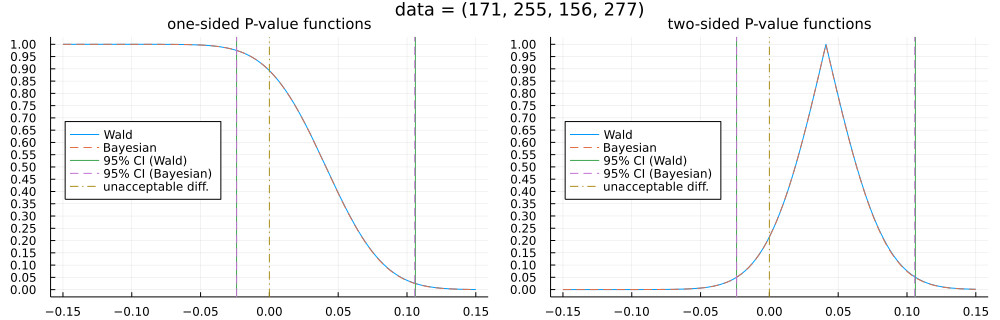

In [9]:
plot_ACCEPT(; data = earnest, unacceptable_diff = 0.0)

通常のP値版とそのBayes的類似物版がグラフ上ではほぼぴったり一致している.

これの片側検定版の図(上の左半分)は[論文](https://arxiv.org/ftp/arxiv/papers/2203/2203.11164.pdf)にあった次の図の再現になっている.

<img src="https://github.com/genkuroki/public/raw/main/0034/2022-08-01a.png" width="70%">

data = (52, 219, 47, 223)
unacceptable_diff = -0.12
riskdiffhat(data...) = 0.017807844745114126
ecdf_rd_bayes._ecdf_delta.sorted_values |> mean = 0.017710910045800932
ecdf_rd_bayes._ecdf_delta.sorted_values |> median = 0.017746255042314543
confint_rd_wald(data...; α = 0.05) = [-0.04745565419044419, 0.08307134368067244]
confint_rd(pvalue_rd_bayes; α = 0.05) = [-0.047332243485870916, 0.08284682811104536]


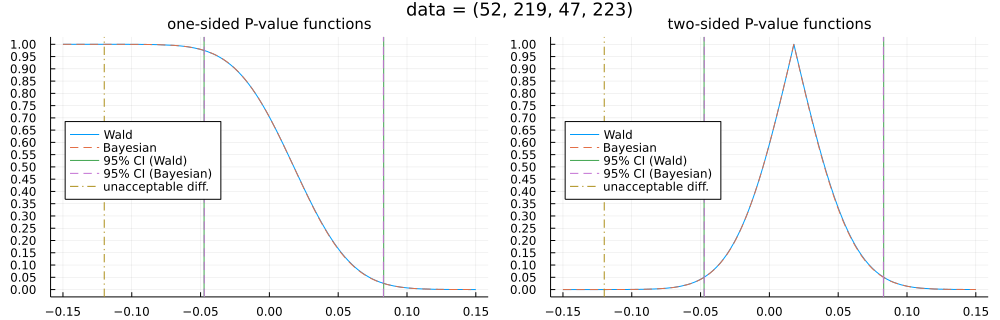

In [10]:
plot_ACCEPT(; data = secondline, unacceptable_diff = -0.12)

これの片側検定版の図(上の左半分)は[論文](https://arxiv.org/ftp/arxiv/papers/2203/2203.11164.pdf)にあった次の図の再現になっている.

<img src="https://github.com/genkuroki/public/raw/main/0034/2022-08-01b.png" width="70%">